# **Step 1: Introduction**
**Introduction: (5 pt)**

Formulate your research question so that you focus on predicting an outcome from the data (i.e prediction of Microcardial Infraction). It can be that your questions in Phase 1 have helped you to determine where to focus during phase 2, or you focus on all the data this time (not on a subset)

Our previous research question was the following:

1. Is the risk of developing CVD the same for people who are healthy and hypertensive patients taking medication against hypertension?

2. How are systolic blood pressure readings correlated with developing CVD?

Since the answer was no to these research questions, I propose to change it to the following:

***What factors influence the development of CVD the most? Can we predict from the given data when CVD and whether CVD will occur?***


# **Step 2: Data Preparation**

**Data preparation: (10 pt)**

Load the dataset in the same way as in Phase
1. Copy the link and load it as we do in our practicals. (5 pt)
2. Select rows and columns relevant to your research question. (5 pt)

Some extra thoughts: may be helpful to create a variable which includes increase in BP/other variable (like heart rate) since last follow up.
We would have to check whether we can include variables like type of CVD developed or similar, as it may introduce data leakage.

In [ ]:
#Import necessary libraries
import pandas as pd
import numpy as np

In [ ]:
# 1. Load dataset from link
cvd = pd.read_csv('https://raw.githubusercontent.com/LUCE-Blockchain/Databases-for-teaching/refs/heads/main/Framingham%20Dataset.csv')

In [ ]:
# 2. Select relevant rows and columns from our research question.

## Relevant columns:

  #Remove columns which would introduce data leakage (not available for machine learning model, would give definite information on the outcome)

  #Remove irrelevant columns (i.e. ID)

cols = [
    "AGE", "SEX", "SYSBP", "DIABP", "TOTCHOL", "BMI",
    "CURSMOKE", "CIGPDAY", "DIABETES", "GLUCOSE",
    "BPMEDS", "PREVHYP", "HEARTRTE", "CVD"
]

In [ ]:
cvd['PERIOD'].value_counts()

,count
PERIOD,
1,4434
2,3930
3,3263


In [ ]:
##Relevant rows:

  #Consider how 'PERIOD' may change. What about dropouts? What if a person dies? Maybe only choose period 3 or 1?
  #Use period 1 because period 1 first of all has a bigger sample, and using period 3 could lead to data leakage
  #because the measurements might already be influenced by disease development. --> We need data before CVD.
  #Looking at other predictive models like the Framingham Risk Score: they also use baseline values

# Only baseline
cvd = cvd[cvd["PERIOD"] == 1]

# Remove people with existing CVD because we want to predict new cases right?
cvd = cvd[(cvd["PREVCHD"] == 0) & (cvd["PREVMI"] == 0) & (cvd["PREVSTRK"] == 0)]

In [ ]:
cvd.sort_values(by='RANDID')[['RANDID', 'BPMEDS', 'CVD']].tail(20)

,RANDID,BPMEDS,CVD
11574,9951428,0.0,0
11575,9951694,0.0,1
11578,9956714,0.0,0
11581,9957743,1.0,0
11582,9960803,0.0,0
11584,9961615,0.0,0
11590,9967157,0.0,1
11593,9968499,0.0,0
11595,9969773,0.0,1
11598,9973350,0.0,0


# **Step 3: Exploring and Cleaning data**
**Explore and clean the data by: (30 pt)**
* Identify, report and correct issues with missing data (if any). (10 pt)
* Identify, report and correct issues with erroneous data (if any). (10 pt)
* Identify and correct outliers (if any). Explain your reasoning. (10 pt)

## Missing Data

In [ ]:
def check_missing(df, col):
    missing  = 0
    misVariables = []
    CheckNull = df.isnull().sum()
    for var in range(0, len(CheckNull)):
        misVariables.append([col[var], CheckNull[var], round(CheckNull[var]/len(df),3)])
        missing = missing + 1

    if missing == 0:
        print('Dataset is complete with no blanks.')
    else:
        df_misVariables = pd.DataFrame.from_records(misVariables)
        df_misVariables.columns = ['Variable', 'Missing', 'Percentage']
        s = df_misVariables.sort_values(by=['Percentage'], ascending=False).style.bar(subset=['Percentage'], color='#d65f5f')
        display(s)
    return df_misVariables

ranked_df_missing_value = check_missing(cvd[cols], cols)

/tmp/ipython-input-272387490.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  misVariables.append([col[var], CheckNull[var], round(CheckNull[var]/len(df),3)])


,Variable,Missing,Percentage
9,GLUCOSE,387,0.092000
4,TOTCHOL,50,0.012000
10,BPMEDS,52,0.012000
7,CIGPDAY,29,0.007000
5,BMI,17,0.004000
1,SEX,0,0.000000
2,SYSBP,0,0.000000
3,DIABP,0,0.000000
0,AGE,0,0.000000
6,CURSMOKE,0,0.000000


In [ ]:
cvd_imputed = cvd.copy()

In [ ]:
#From phase 1
# If NOT hypertensive -> impute BPMEDS with 0
cvd_imputed.loc[
    (cvd_imputed['PREVHYP'] == 0) & (cvd_imputed['BPMEDS'].isna()),
    'BPMEDS'
] = 0

# If hypertensive & BPMEDS missing -> drop (slechts klein %)
cvd_imputed = cvd_imputed.dropna(subset=['BPMEDS'])

In [ ]:
#GLUCOSE, TOTCHOL, BMI, HEARTRTE -> impute with median
num_cols_median = ["GLUCOSE", "TOTCHOL", "BMI", "HEARTRTE"]

for col in num_cols_median:
    median_val = cvd_imputed[col].median()
    cvd_imputed[col] = cvd_imputed[col].fillna(median_val)

In [ ]:
#If someone is no smoker (0) and CIGPDAY is missing --> impute with 0
cvd_imputed.loc[
    (cvd_imputed['CURSMOKE'] == 0) & (cvd_imputed['CIGPDAY'].isna()),
    'CIGPDAY'
] = 0


In [ ]:
#If someone is a smoker (1) and CIGPDAY is missing --> impute with median from smokers
median_cigs_smokers = cvd_imputed.loc[
    cvd_imputed['CURSMOKE'] == 1, 'CIGPDAY'
].median()

cvd_imputed.loc[
    (cvd_imputed['CURSMOKE'] == 1) & (cvd_imputed['CIGPDAY'].isna()),
    'CIGPDAY'
] = median_cigs_smokers

In [ ]:
ranked_df_missing_value_imputed = check_missing(cvd_imputed[cols], cols)

/tmp/ipython-input-272387490.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  misVariables.append([col[var], CheckNull[var], round(CheckNull[var]/len(df),3)])
/usr/local/lib/python3.12/dist-packages/pandas/io/formats/style.py:4040: RuntimeWarning: invalid value encountered in scalar divide
  end = (x - left) / (right - left)


,Variable,Missing,Percentage
0,AGE,0,0.000000
1,SEX,0,0.000000
2,SYSBP,0,0.000000
3,DIABP,0,0.000000
4,TOTCHOL,0,0.000000
5,BMI,0,0.000000
6,CURSMOKE,0,0.000000
7,CIGPDAY,0,0.000000
8,DIABETES,0,0.000000
9,GLUCOSE,0,0.000000


## Erroneous data

In [ ]:
#Identify suspicous values
erroneous_checks = {
    "AGE": (30, 90),
    "SYSBP": (70, 260),
    "DIABP": (30, 150),
    "BMI": (10, 70),
    "GLUCOSE": (40, 400),
    "HEARTRTE": (30, 220),
    "CIGPDAY": (0, 80)
}

for col, (low, high) in erroneous_checks.items():
    invalid = cvd_imputed[(cvd_imputed[col] < low) | (cvd_imputed[col] > high)]
    print(f"{col}: {len(invalid)} suspicious values")

AGE: 0 suspicious values
SYSBP: 1 suspicious values
DIABP: 0 suspicious values
BMI: 0 suspicious values
GLUCOSE: 0 suspicious values
HEARTRTE: 0 suspicious values
CIGPDAY: 0 suspicious values


In [ ]:
#Check CIGPDAY but no smoking
inconsistent_smoking = cvd_imputed[
    (cvd_imputed["CURSMOKE"] == 0) & (cvd_imputed["CIGPDAY"] > 0)
]
print("Inconsistent smoking rows:", len(inconsistent_smoking))

Inconsistent smoking rows: 0


In [ ]:
#Check no PREVHYP but medicine
inconsistent_bpmeds = cvd_imputed[
    (cvd_imputed["PREVHYP"] == 0) & (cvd_imputed["BPMEDS"] == 1)
]
print("Inconsistent BP meds rows:", len(inconsistent_bpmeds))

Inconsistent BP meds rows: 0


In [ ]:
#Make them missing values
for col, (low, high) in erroneous_checks.items():
    cvd_imputed.loc[
        (cvd_imputed[col] < low) | (cvd_imputed[col] > high),
        col
    ] = np.nan

In [ ]:
#Impute them again
#Numeric variables --> median
num_cols_median = ["GLUCOSE", "TOTCHOL", "BMI", "HEARTRTE","SYSBP"]

for col in num_cols_median:
    cvd_imputed[col] = cvd_imputed[col].fillna(cvd_imputed[col].median()) #Change to capping instead? If you do, do it after outliers

#CIGPDAY dependent on smoking status
# Non-smokers --> 0
cvd_imputed.loc[
    (cvd_imputed['CURSMOKE'] == 0) & (cvd_imputed['CIGPDAY'].isna()),
    'CIGPDAY'
] = 0

# Smokers --> median
median_cigs = cvd_imputed.loc[cvd_imputed['CURSMOKE'] == 1, 'CIGPDAY'].median()
cvd_imputed.loc[
    (cvd_imputed['CURSMOKE'] == 1) & (cvd_imputed['CIGPDAY'].isna()),
    'CIGPDAY'
] = median_cigs

In [ ]:
cvd_imputed[cols].isna().sum()

,0
AGE,0
SEX,0
SYSBP,0
DIABP,0
TOTCHOL,0
BMI,0
CURSMOKE,0
CIGPDAY,0
DIABETES,0
GLUCOSE,0


## Identify and correct outliers

In [ ]:
boxplot_vars = [
    "SYSBP", "DIABP", "TOTCHOL",
    "GLUCOSE", "BMI", "HEARTRTE", "CIGPDAY"
]


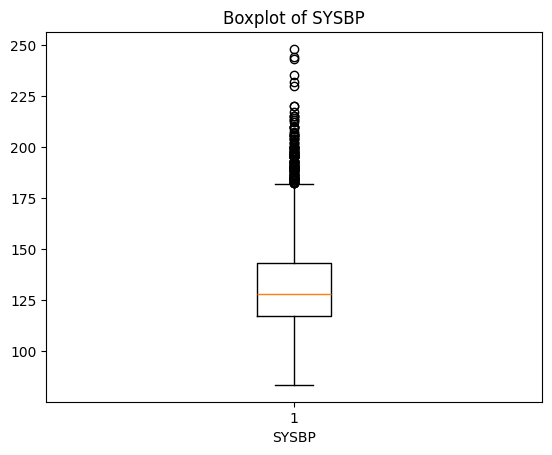

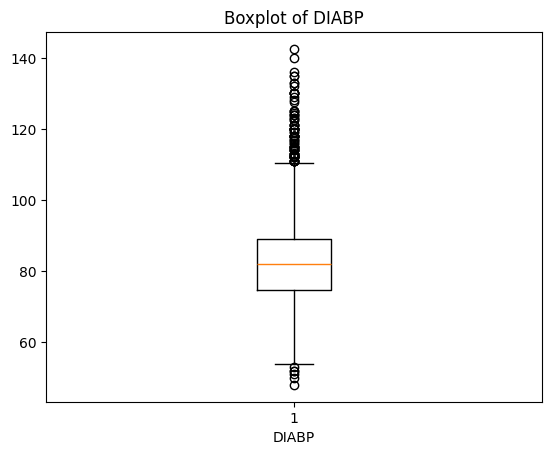

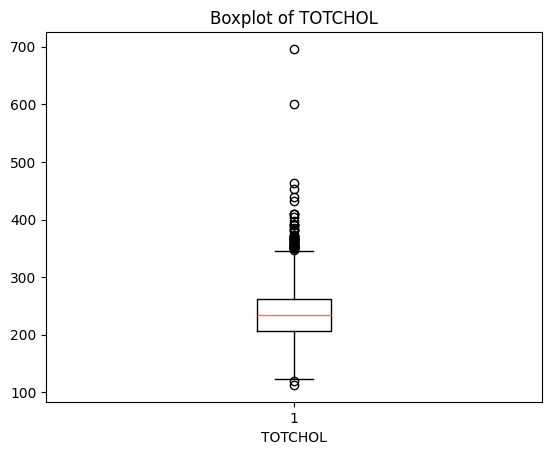

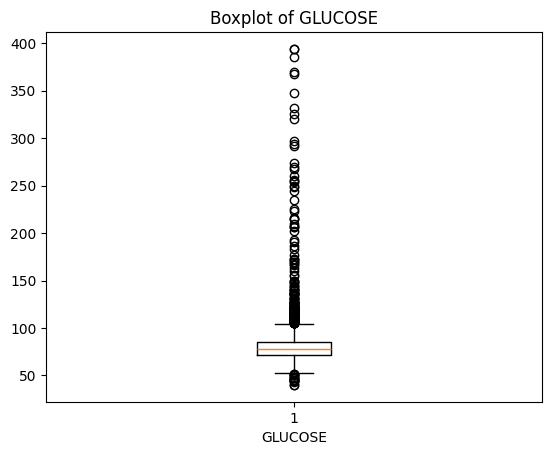

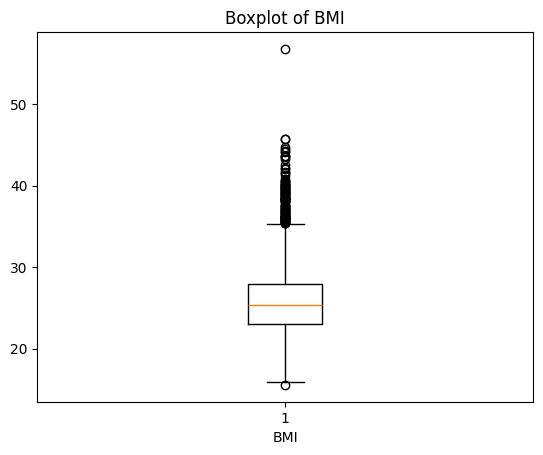

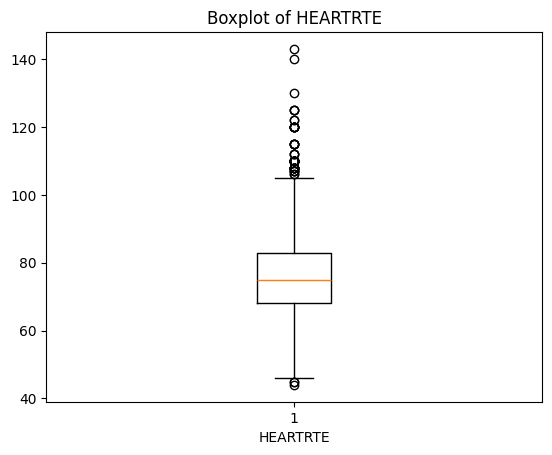

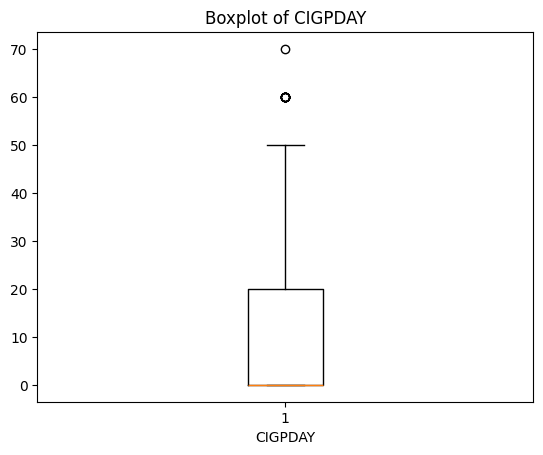

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.pyplot as plt

for var in boxplot_vars:
    plt.figure()
    plt.boxplot(cvd_imputed[var].dropna())
    plt.title(f"Boxplot of {var}")
    plt.xlabel(var)
    plt.show()

In [ ]:
#Same as in phase 1
cvd_imputed.loc[cvd_imputed['SYSBP'] > 250, 'SYSBP'] = 250
cvd_imputed.loc[cvd_imputed['DIABP'] < 40, 'DIABP'] = 40
cvd_imputed.loc[cvd_imputed['DIABP'] > 120, 'DIABP'] = 120
cvd_imputed.loc[cvd_imputed['TOTCHOL'] > 500, 'TOTCHOL'] = 500
cvd_imputed.loc[cvd_imputed['GLUCOSE'] > 400, 'GLUCOSE'] = 400
cvd_imputed.loc[cvd_imputed['BMI'] > 55, 'BMI'] = 55
cvd_imputed.loc[cvd_imputed['HEARTRTE'] > 200, 'HEARTRTE'] = 200
cvd_imputed.loc[cvd_imputed['CIGPDAY']> 80, 'CIGPDAY'] = 80

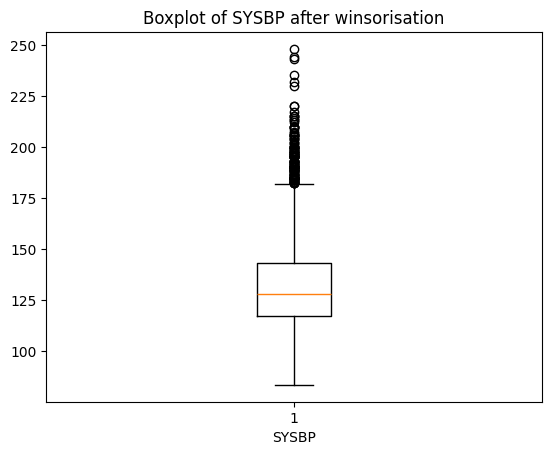

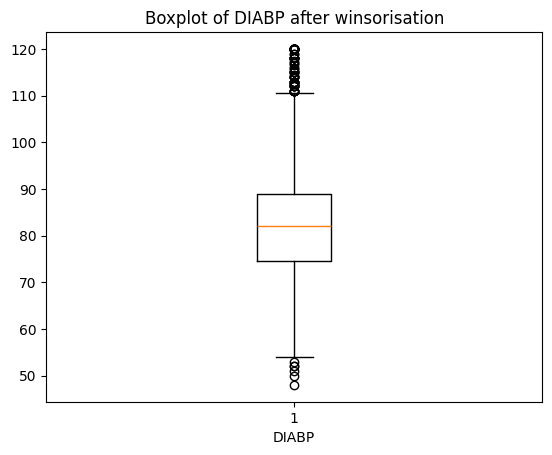

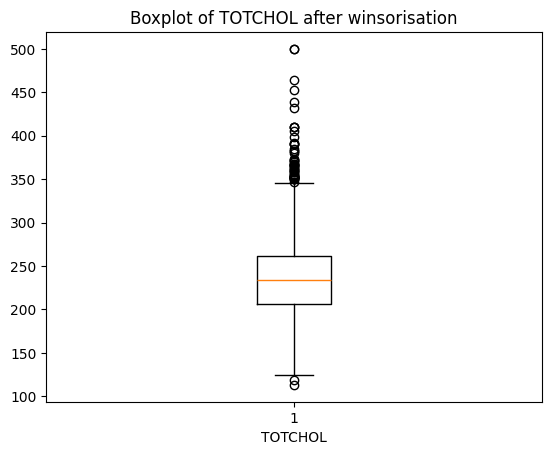

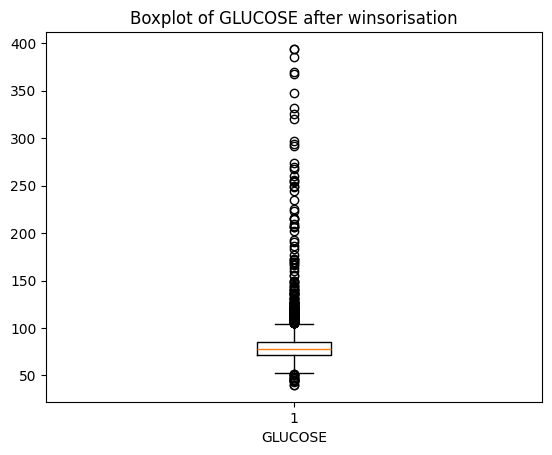

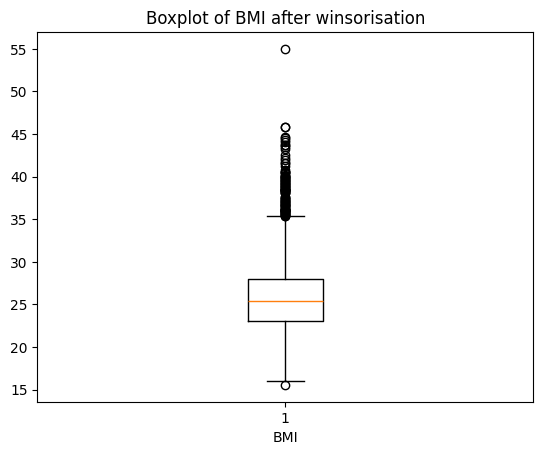

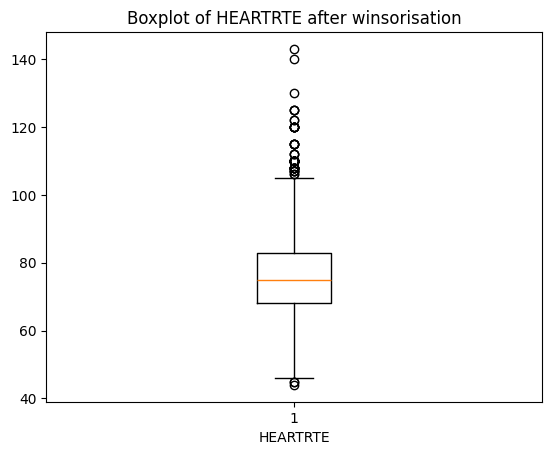

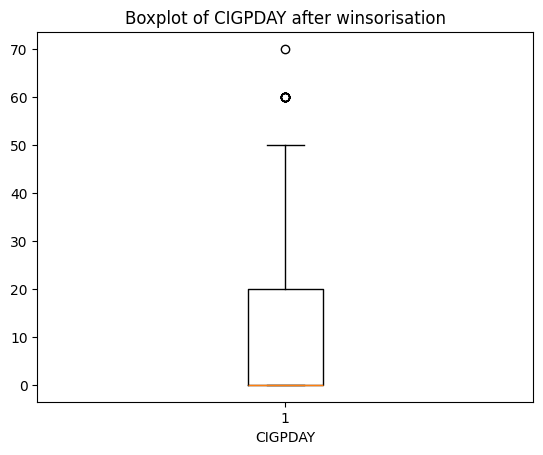

In [ ]:
#Control
for var in boxplot_vars:
    plt.figure()
    plt.boxplot(cvd_imputed[var])
    plt.title(f"Boxplot of {var} after winsorisation")
    plt.xlabel(var)
    plt.show()

In [ ]:
cvd_imputed = cvd_imputed[cols]

In [ ]:
cvd_imputed.isna().sum()

,0
AGE,0
SEX,0
SYSBP,0
DIABP,0
TOTCHOL,0
BMI,0
CURSMOKE,0
CIGPDAY,0
DIABETES,0
GLUCOSE,0


**# Step 4: Describing and visualising the data**
**Describe and visualize: (25 pt)**
* Provide a summary of your cohort, this is a description of the final clean data. Make use of a table with descriptive statistics (i.e. means, medians, standard deviations) of important variables such as age, gender, outcome ect. Where possible, use visualisations. (10pt)
* Make the report interactive: Create at least one interactive visualisation using input from the user. (10pt)
* Turn your interactive report into an application using GitHub, Voila and Binder. (5pt)

## Cohort Summary (descriptives)

##Make Interactive report

#**Step 5: Data analysis**
**Data analysis: (25 pt)**
* Perform feature engineering on the data to better apply AI models to them (5pt)
* After splitting the data in a way that you can at a minimum test and train, apply several prediction models to your data. (10pt)
* Use performance metrics to determine the best model (5 pt)
* Apply further hyper-parameter tuning, or cross validation if possible. (5 pt)

##Preprocessing:

* Datascaling

## Relevant functions

In [ ]:
### REQUIRED LIBRARIES ###
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict


import matplotlib.pyplot as plt

Splitting into output and input

In [ ]:
def splitLabels(df, target): #target has to be typed exactly the same
  X = df.loc[:, df.columns != target] # Correctly select columns, not rows
  y = df[target]
  return X, y # Return X and y

Training logistic regression model with confusion matrix

In [ ]:
def trainLogReg(X, y, max_iter = 1000, test_size=0.2, random_state=380):
  # Step 1: we use the same train-test split as above
  train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=test_size, stratify=y, random_state=random_state)

  from sklearn.preprocessing import MinMaxScaler
  min_max_scaler = MinMaxScaler()
  train_X = min_max_scaler.fit_transform(train_X)

  # Step 2: Pick the algorithm
  logreg = LogisticRegression(max_iter=max_iter) #max_iter=1000 threw an error, so I increased it

  # Step 3: Train the classifier
  logreg = logreg.fit(train_X, train_y)

  # Step 4: Make a prediction
  y_pred_logreg = logreg.predict(test_X)

  #Cross validation:
  cv_value = 5
  cv_scores = cross_val_score(logreg, train_X, train_y, scoring='accuracy', cv=cv_value)

  # Step 4: Make a prediction
  prediction = cross_val_predict(logreg, train_X, train_y, cv=cv_value)

  # Step 5: Evaluate the prediction
  print('Used model is: {}-----------'.format(logreg))
  print('classifier stored as "logreg"')
  print(classification_report(test_y, y_pred_logreg))
  # Step 5: Evaluate the prediction by looking at the mean of multiple accuracy scores
  print(f"Cross validation score: {cv_scores.mean().round(2)} accuracy with a standard deviation of {cv_scores.std().round(2)}")


  cm = confusion_matrix(y_true=test_y,
                  y_pred=y_pred_logreg,
                  normalize='true')

  disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                display_labels=logreg.classes_)

  disp.plot();

Training KNN model with confusion matrix

In [ ]:
def trainKNN(X, y, neighbors = 5, test_size=0.2, random_state=380):
  # Step 1: we use the same train-test split as above
  train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=test_size, stratify=y, random_state=random_state)

  # Step 2: Pick the algorithm
  # TODO: HOW DO WE DEFINE THE CLASSIFIER?
  ### YOUR CODE HERE
  knn = KNeighborsClassifier(n_neighbors=neighbors, weights='uniform')

  # Step 3: Train the classifier
  knn = knn.fit(train_X, train_y)

  # Step 4: Make a prediction
  y_pred_knn = knn.predict(test_X)

  #Cross validation:
  cv_value = 5
  cv_scores = cross_val_score(knn, X_train, y_train, scoring='accuracy', cv=cv_value)

  # Step 4: Make a prediction
  prediction = cross_val_predict(knn, X_test, y_test, cv=cv_value)

  # Step 5: Evaluate the prediction

  print('Used model is: {}-----------'.format(knn))
  print('classifier stored as "knn"')
  print('\n', classification_report(test_y, y_pred_knn))
  # Step 5: Evaluate the prediction by looking at the mean of multiple accuracy scores
  print(f"Cross validation score: {cv_scores.mean().round(2)} accuracy with a standard deviation of {cv_scores.std().round(2)}")

  cm = confusion_matrix(y_true=test_y,
                  y_pred=y_pred_knn,
                  normalize='true')

  disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                display_labels=clf.classes_)

  disp.plot();

Training random forest model with confusion matrix

In [ ]:
def trainRF(X, y, test_size=0.2, max_depth=4, random_state=380):

  # Step 1: we use the same train-test split as above
  train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=test_size, stratify=y, random_state=random_state)

  # Step 2: Pick the algorithm
  RF = RandomForestClassifier(max_depth=max_depth, random_state=random_state)

  # Step 3: Train the classifier
  RF.fit(train_X, train_y)

  # Step 4: Make a prediction
  y_pred_RF = RF.predict(test_X)

  #Cross validation:
  cv_value = 5
  cv_scores = cross_val_score(RF, X_train, y_train, scoring='accuracy', cv=cv_value)

  # Step 4: Make a prediction
  prediction = cross_val_predict(RF, X_test, y_test, cv=cv_value)

  # Step 5: Evaluate the prediction
  print('Used model is: {}-----------'.format(RF))
  print('classifier stored as "RF"')
  print('\n', classification_report(test_y, y_pred_RF))
  print(f"Cross validation score: {cv_scores.mean().round(2)} accuracy with a standard deviation of {cv_scores.std().round(2)}")

  cm = confusion_matrix(y_true=test_y,
                  y_pred=y_pred_RF,
                  normalize='true')

  disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                display_labels=clf.classes_)

  disp.plot();

AUC for logistic regression

In [ ]:
def modelEvaluationLogReg(test_X, test_y):

  #Make false and true positive rates
  y_prob_logreg = logreg.predict_proba(test_X)[:,1]

  fpr_logreg, tpr_logreg, thresholds_logreg = roc_curve(test_y, y_prob_logreg)
  auc_logreg = auc(fpr_logreg, tpr_logreg)

  fig, ax = plt.subplots()
  ax.plot([0, 1], [0, 1], 'k--')
  ax.plot(fpr_logreg, tpr_logreg, label='Logistic Regression (area = {:.2f})'.format(auc_logreg))
  ax.set(xlabel='False positive rate',
        ylabel='True positive rate (Recall)',
        title='ROC curve')
  ax.legend(loc='best');

AUC for KNN

In [ ]:
def modelEvaluationKNN(test_X, test_y):

  #Make false and true positive rates
  y_prob_logreg = logreg.predict_proba(test_X)[:,1]

  fpr_logreg, tpr_logreg, thresholds_logreg = roc_curve(test_y, y_prob_logreg)
  auc_logreg = auc(fpr_logreg, tpr_logreg)

  fig, ax = plt.subplots()
  ax.plot([0, 1], [0, 1], 'k--')
  ax.plot(fpr_logreg, tpr_logreg, 'tab:green', label='KNN (area = {:.2f})'.format(auc_logreg))
  ax.set(xlabel='False positive rate',
        ylabel='True positive rate (Recall)',
        title='ROC curve')
  ax.legend(loc='best');

AUC for random forest

In [ ]:
def modelEvaluationRF(test_X, test_y):

  #Make false and true positive rates
  y_prob_RF = RandomForestClassifier.predict_proba(test_X)[:,1]

  fpr_RF, tpr_RF, thresholds_RF= roc_curve(test_y, y_prob_RF)
  auc_RF = auc(fpr_RF, tpr_RF)

  fig, ax = plt.subplots()
  ax.plot([0, 1], [0, 1], 'k--')
  ax.plot(fpr_RF, tpr_RF, 'tab:red', label='Random Forest (area = {:.2f})'.format(auc_RF))
  ax.set(xlabel='False positive rate',
        ylabel='True positive rate (Recall)',
        title='ROC curve')
  ax.legend(loc='best');

## Feature engineering

##Training predictive models

In [ ]:
X, y = splitLabels(cvd_imputed, target='CVD')

In [ ]:
X = cvd_imputed.drop(labels='CVD', axis=1)
y = cvd_imputed['CVD']

In [ ]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
train_X = min_max_scaler.fit_transform(train_X)

NameError: name 'train_X' is not defined

In [ ]:
trainLogReg(X, y, max_iter=2000)

## Performance metrics

## Hyperparameter tuning

#Step 6: Conclusion
**Conclusion: (5 pt)**
Summarize the work and the main findings related to the initial research question. (5 pt)

# Import Libraries & load df


# Begin analysis (full dataset)

In [ ]:
cvd.sort_values(by='RANDID')[['RANDID', 'PREVHYP']].head(50)

In [ ]:
cvd.describe()

In [ ]:
#Population descriptives (sex, age, weight, BP, etc etc)
numerical_vars = ['AGE', 'BMI', 'SYSBP', 'DIABP', 'TOTCHOL', 'CIGPDAY', 'HEARTRTE', 'GLUCOSE']
cvd[numerical_vars].describe()

In [ ]:
# Kopie van dataset met alleen die kolommen
desc = cvd[numerical_vars].copy()

# Definieer een functie om median + IQR te berekenen
def median_iqr(series):
    return f"{series.median():.1f} ({series.quantile(0.25):.1f}–{series.quantile(0.75):.1f})"

# Bereken de descriptives
desc_table = pd.DataFrame({
    'Mean (SD)': [f"{desc[var].mean():.1f} ({desc[var].std():.1f})" if desc[var].dtype != 'O' else np.nan for var in numerical_vars],
    'Median (IQR)': [median_iqr(desc[var]) if np.issubdtype(desc[var].dtype, np.number) else np.nan for var in numerical_vars],
    'Min': [desc[var].min() for var in numerical_vars],
    'Max': [desc[var].max() for var in numerical_vars]
}, index=numerical_vars)

# Toon tabel
desc_table

In [ ]:
cvd['BPMEDS'].mean()*100

In [ ]:
cvd['CVD'].mean()*100

In [ ]:
cvd['SEX'].mean()

In [ ]:
import matplotlib as plt

In [ ]:
sex_counts = cvd['SEX'].value_counts().sort_index()

sex_counts.plot.pie(
    labels=['Male', 'Female'],  # 1 = Male, 2 = Female
    autopct='%1.0f%%',
    colors=['#4A90E2', '#FF69B4'],
    startangle=90,
    textprops={'fontsize': 12, 'color': 'black'}
)



In [ ]:
#percentages for categorical variables --> idk if needed
categorical_vars = ['SEX', 'CURSMOKE', 'DIABETES', 'HYPERTEN','BPMEDS','CVD']
for col in categorical_vars:
   print(f"\n=== {col} ===")
   print(cvd[col].value_counts(dropna=False))  # aantallen
   print((cvd[col].value_counts(normalize=True, dropna=False) * 100).round(1))


In [ ]:
#Use descriptive statistics
cvd.describe()

In [ ]:
#Use visualisation (i.e. histogram, bar chart) -> use box plot for age, sysbp & other population information that is continuous (i.e. cigarettes smoked)
#distributions for population descriptives
import matplotlib.pyplot as plt
cvd.hist(grid=False, # Remove grid
                        xlabelsize=10, # Change size of labels on the x-axis
                        ylabelsize=12, # Change size of labels on the y-axis
                        bins=20, # Number of bins
                        figsize=(10,10),
                        edgecolor='blue', # Color of the border
                        color='pink', # Color of the bins
                        rwidth=0.8 # Space between bins
                       )
# Add label names
plt.suptitle("distribution of key numerical variables")
plt.show()

In [ ]:
#Use visualisation (i.e. histogram, bar chart) -> use box plot for age, sysbp & other population information that is continuous (i.e. cigarettes smoked)
#distributions for population descriptives
import matplotlib.pyplot as plt
import seaborn as sns

for var in numerical_vars:
    plt.figure(figsize=(12, 6))
    sns.boxplot(x=cvd[var], color=sns.color_palette('Set2')[1])
    plt.title(f'Boxplot of {var}')
    plt.xlabel(var)
    plt.show()

In [ ]:
cvd_raw = cvd.copy()

In [ ]:
cvd.loc[cvd['SYSBP'] > 250, 'SYSBP'] = 250
cvd.loc[cvd['DIABP'] < 40, 'DIABP'] = 40
cvd.loc[cvd['DIABP'] > 120, 'DIABP'] = 120
cvd.loc[cvd['TOTCHOL'] > 500, 'TOTCHOL'] = 500
cvd.loc[cvd['GLUCOSE'] > 400, 'GLUCOSE'] = 400
cvd.loc[cvd['BMI'] > 55, 'BMI'] = 55
cvd.loc[cvd['HEARTRTE'] > 200, 'HEARTRTE'] = 200

In [ ]:
def compare_boxplots(var):
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    sns.boxplot(y=cvd_raw[var], ax=axes[0])
    axes[0].set_title(f'{var} - Before winsorizing')
    sns.boxplot(y=cvd[var], ax=axes[1])
    axes[1].set_title(f'{var} - After winsorizing')
    plt.tight_layout()
    plt.show()

compare_boxplots('HEARTRTE')

In [ ]:
def compare_boxplots(var):
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    sns.boxplot(y=cvd_raw[var], ax=axes[0])
    axes[0].set_title(f'{var} - Before winsorizing')
    sns.boxplot(y=cvd[var], ax=axes[1])
    axes[1].set_title(f'{var} - After winsorizing')
    plt.tight_layout()
    plt.show()

compare_boxplots('GLUCOSE')

In [ ]:
#If needed, check outlier & remove/impute outliers

#SYSBP >250 --> winsorized to 250
#DIABP <40/>120 --> winsorized
#TOTCHOL >500 --> winsorized
#GLUCOSE >400 --> winsorized
#BMI>55 --> winsorized
#HEARTRTE >200 --> winsorized to 200

#show how distribution changes after removal/imputation

In [ ]:
#Use descriptive statistics per subgroup (healthy, hypertensive meds, hypertensive no meds)
cvd.groupby(['PREVHYP', 'BPMEDS']).agg(
    N =('AGE', 'count'),
    Mean_AGE = ('AGE','mean'),
    Mean_SYSBP = ('SYSBP', 'mean'),
    Mean_DIABP=('DIABP','mean'),
    Mean_BMI=('BMI','mean'),
    CVD_Rate=('CVD','mean')
)
 #extend for other variables

# Analysis target variables

Note: research question is:

Is the risk of developing CVD the same for people who are healthy and hypertensive patients taking medication?
Similarly: is/how is sysbp correlated with cvd?

In [ ]:
#Select only relevant columns (BPMEDS, SYSBP, PREVHYP)
cvd_selected = cvd[['PREVHYP', 'SYSBP', 'BPMEDS', 'CVD']]
cvd_selected

# Handling missing data

In [ ]:
#Identify missings
display(cvd_selected.isna().sum()) #oh no!!!
display(cvd_selected.isna().mean()*100) #shows percentage

In [ ]:
#Copy paste from workshop the missing % bc looks nicer :)
### check if there is any missing value in the dataset ###
def check_missing(df, col):
    missing  = 0
    misVariables = []
    CheckNull = df.isnull().sum()
    for var in range(0, len(CheckNull)):
        misVariables.append([col[var], CheckNull[var], round(CheckNull[var]/len(df),3)])
        missing = missing + 1

    if missing == 0:
        print('Dataset is complete with no blanks.')
    else:
        df_misVariables = pd.DataFrame.from_records(misVariables)
        df_misVariables.columns = ['Variable', 'Missing', 'Percentage']
        s = df_misVariables.sort_values(by=['Percentage'], ascending=False).style.bar(subset=['Percentage'], color='#d65f5f')
        display(s)
    return df_misVariables

ranked_df_missing_value = check_missing(cvd, cvd.columns)

Think about what type this missingness is (MCAR, MAR, MNAR?)

In [ ]:
#aantal doden
cvd[cvd['DEATH'] == 1]['RANDID'].nunique()

In [ ]:
cvd[(cvd['TIMEDTH'].isnull()) & (cvd['TIMECVD'].isnull())].shape

In [ ]:
cvd['BPMEDS_missing'] = cvd['BPMEDS'].isna().astype(int)
print ('Missingness in BPMEDS by age')
print (cvd.groupby('BPMEDS_missing')['AGE'].mean())
print("\nCross-tab with sex:")
print(pd.crosstab(cvd['BPMEDS_missing'], cvd['SEX']))
# dont think that age/sex has anything to do with missingness

In [ ]:
cvd.PERIOD.value_counts()
print("\nCross-tab with examination cycle:")
print(pd.crosstab(cvd['BPMEDS_missing'], cvd['PERIOD']))

In [ ]:
#Seeing if the prevelance of PREVHYP changes with period
cvd.groupby(['PERIOD', 'BPMEDS'])['PREVHYP'].mean()

In [ ]:
#See if missing instances (meaning patients) depends on any variable
 #(i.e. seem to have generally been younger, or maybe they were female (pregnant), etc..)

In [ ]:
#First check total of prevhyp (compare with totals after imputation/removal)
cvd_selected.groupby('PREVHYP')['PREVHYP'].count()

In [ ]:
#Select rows based on whether they're missing
cvd_isna = cvd_selected[cvd_selected['BPMEDS'].isna()] #selects if row for BPMEDS is not a number
#Check what group has the missings (hypertensive or not)
cvd_isna.groupby('PREVHYP')['PREVHYP'].count()

In [ ]:
#If NOT hypertensive -> Impute BPMEDS with 0 bc de missingness is probably not MCAR bc they are probably not using BPMDEDS
cvd_selected.loc[(cvd_selected['PREVHYP'] == 0) & (cvd_selected['BPMEDS'].isna()), 'BPMEDS'] = 0

In [ ]:
#If hypertensive -> remove the columns of 'BPMEDS' missings bc its only 3%
cvd_selected = cvd_selected.dropna(subset=['BPMEDS'])
display(cvd_selected.isna().sum()) #oh no!!!

:Note: thinking about how sysbp may be different for medicated and non medicated patients. Can we determine whether they actually were medicated or not by checking their sysbp values?

In [ ]:
# checking
cvd_selected.groupby('PREVHYP')['PREVHYP'].count()

In [ ]:
#Association between deaths and drop outs?
cvd.groupby('PERIOD').agg(
    Count_Patients=('RANDID', 'count'),
    Amount_of_deaths=('DEATH', lambda x: (x == 1).sum()) #From here you should be able to see that in period 2 more people died than the amount of patients
    #was reduced from period 1 to 2.
)

# Further analysis of target variables


In [ ]:
#imports
# First, we need these modules for the basics of data manipulation
import numpy as np
import pandas as pd

# This part is for the plotting
import matplotlib.pyplot as plt
import seaborn as sns

# This one is just to access the dataset
from sklearn import datasets

# You can set a general style for your plots like this
plt.style.use('ggplot')
# plt.style.use('seaborn-whitegrid')

In [ ]:
#Maybe small correlation matrix with our selected variables. Is there any correlation, if yes, how?

sns.set_theme(style="white")

# Compute the correlation matrix
corr = cvd_selected.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 5))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=0.5, vmin=-0.5, center=0,annot = True,
             linewidths=.5, cbar_kws={"shrink": .8})

In [ ]:
#Logistic regression plot. y axis = BPMEDs (yes or no) and on x-axis = sysbp

x = cvd_selected.SYSBP #Just to spell it out
y = cvd_selected.CVD

sns.regplot(x=x, y=y, data=cvd_selected, logistic=True, ci=None) #This does not consider whether they take meds or not!

In [ ]:
#Logistic regression plot. y axis = BPMEDs (yes or no) and on x-axis = sysbp
cvd_no_meds = cvd_selected[cvd_selected['BPMEDS'] == 0]

x = cvd_no_meds.SYSBP
y = cvd_no_meds.CVD

sns.regplot(x=x, y=y, data=cvd_no_meds, logistic=True, ci=None)

In [ ]:
#Visualise association between sysbp and cvd (box plot)

cvd_selected['subgroup'] = 'Healthy'
cvd_selected.loc[(cvd_selected['PREVHYP'] == 1) & (cvd_selected['BPMEDS'] == 0 ), 'subgroup'] = 'Unmedicated'
cvd_selected.loc[(cvd_selected['PREVHYP'] == 1) & (cvd_selected['BPMEDS'] == 1 ), 'subgroup'] = 'Medicated'

display(cvd_selected.subgroup.value_counts())

sns.boxplot(x='subgroup', y='SYSBP', data=cvd_selected, orient="v", palette="Set3", order=['Healthy', 'Unmedicated', 'Medicated'])

In [ ]:
sns.boxplot(x='PREVHYP', y='SYSBP', data=cvd_selected, orient="v", palette="Set3")

In [ ]:
cvd_selected.shape

In [ ]:
#Remove outliers if sysbp > 250
cvd_before = cvd_selected
print('Maximum values before:', cvd_selected.SYSBP.max())
cvd_selected = cvd_selected[cvd_selected['SYSBP'] <= 200]
print(f'Amount of rows excluded: {cvd_before.shape[0] - cvd_selected.shape[0]}')
print('Maximum values after:', cvd_selected.SYSBP.max())

In [ ]:
counts = cvd_selected.groupby('subgroup')['subgroup'].count()

In [ ]:
#Make visualisation of subgroups (i.e. piechart with % of instances per subgroup)
fig, ax = plt.subplots()
ax.pie(counts, labels=['Healthy', 'Medicated Hypertensive', 'Unmedicated Hypertensive'], colors=['c','y','r'], startangle=90, shadow= True, autopct='%1.1f%%')
ax.set(title='Distribution of Subgroups');


In [ ]:
# Group by patient ID and check if CVD occurred at any point
cvd_unique_patients = cvd.groupby('RANDID')['CVD'].max().reset_index()

# Rename the column for clarity
cvd_unique_patients = cvd_unique_patients.rename(columns={'CVD': 'Ever_Developed_CVD'})

display(cvd_unique_patients.head())
display(cvd_unique_patients['Ever_Developed_CVD'].value_counts())

In [ ]:
counts = cvd_unique_patients.groupby('Ever_Developed_CVD')['Ever_Developed_CVD'].count()

#Make visualisation of subgroups (i.e. piechart with % of instances per subgroup)
fig, ax = plt.subplots()
ax.pie(counts, labels=['No CVD', 'CVD'], colors=['c','y'], startangle=90, shadow= True, autopct='%1.1f%%')
ax.set(title='Patients which developed CVD over the study period');


Define colours for each of the bars like in all previous images

In [ ]:
#Bar chart -> % cvd per subgroup
by_meds = cvd_selected.groupby(['PREVHYP', 'BPMEDS'])['CVD'].mean()
display(by_meds)

# we reset the index so 'gender' also becomes a column (instead of the row index)
by_meds = by_meds.reset_index()

fig, ax = plt.subplots()
# Define labels for the subgroups
labels = ['Healthy', 'Unmedicated', 'Medicated']
# Plot the bar chart
ax.bar(labels, by_meds.CVD)
ax.set(title='CVD risk by medication and hypertensive status');